In [1]:
from IPython.core.display import Image

from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio import SeqIO
from Bio.Graphics import BasicChromosome

In [2]:
!rm -f PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta 2>/dev/null
!wget http://plasmodb.org/common/downloads/release-9.3/Pfalciparum3D7/fasta/data/PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta

--2020-12-04 12:18:47--  http://plasmodb.org/common/downloads/release-9.3/Pfalciparum3D7/fasta/data/PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta
Resolving plasmodb.org (plasmodb.org)... 128.192.21.13
Connecting to plasmodb.org (plasmodb.org)|128.192.21.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://plasmodb.org/common/downloads/release-9.3/Pfalciparum3D7/fasta/data/PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta [following]
--2020-12-04 12:18:47--  https://plasmodb.org/common/downloads/release-9.3/Pfalciparum3D7/fasta/data/PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta
Connecting to plasmodb.org (plasmodb.org)|128.192.21.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23723399 (23M) [application/x-fasta]
Saving to: ‘PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta’

PlasmoDB-9.3_Pfalci 100%[===================>]  22.62M  2.98MB/s    in 7.3s    

2020-12-04 12:18:55 (3.10 MB/s) - ‘PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta’ saved [

### 1. Inspecting the description of all of the the sequences on the reference genome FASTA file

In [2]:
genome_name = '../datasets/PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta'

In [3]:
recs = SeqIO.parse(genome_name, 'fasta')
chroms = {}
for rec in recs:
    print(rec.description)

Pf3D7_05_v3 | organism=Plasmodium_falciparum_3D7 | version=2012-02-01 | length=1343557 | SO=chromosome
Pf3D7_10_v3 | organism=Plasmodium_falciparum_3D7 | version=2012-02-01 | length=1687656 | SO=chromosome
Pf3D7_07_v3 | organism=Plasmodium_falciparum_3D7 | version=2012-02-01 | length=1445207 | SO=chromosome
Pf3D7_03_v3 | organism=Plasmodium_falciparum_3D7 | version=2012-02-01 | length=1067971 | SO=chromosome
Pf3D7_13_v3 | organism=Plasmodium_falciparum_3D7 | version=2012-02-01 | length=2925236 | SO=chromosome
Pf3D7_11_v3 | organism=Plasmodium_falciparum_3D7 | version=2012-02-01 | length=2038340 | SO=chromosome
Pf3D7_14_v3 | organism=Plasmodium_falciparum_3D7 | version=2012-02-01 | length=3291936 | SO=chromosome
Pf3D7_09_v3 | organism=Plasmodium_falciparum_3D7 | version=2012-02-01 | length=1541735 | SO=chromosome
Pf3D7_01_v3 | organism=Plasmodium_falciparum_3D7 | version=2012-02-01 | length=640851 | SO=chromosome
Pf3D7_12_v3 | organism=Plasmodium_falciparum_3D7 | version=2012-02-01 | le

Different genome references will have different description lines, but they will generally have important information. In this example, you can see that we have chromosomes, mitochondria, and apicoplast. We can also view chromosome sizes, but we will take the value from the sequence length instead.

### 2. Parse the description line to extract the chromosome number
We will retrieve the chromosome size from the sequence, and compute the GC content across chromosomes on a window basis:

In [4]:
from Bio import SeqUtils

chrom_sizes = {}
chrom_GC = {}
recs = SeqIO.parse(genome_name, 'fasta')
block_size = 50000
min_GC = 100.0
max_GC = 0.0
for rec in recs:
    if rec.description.find('SO=chromosome') == -1:
        continue
    chrom = int(rec.description.split('_')[1])
    chrom_GC[chrom] = []
    size = len(rec.seq)
    chrom_sizes[chrom] = size
    num_blocks = size // block_size + 1
    for block in range(num_blocks):
        start = block_size * block
        if block == num_blocks - 1:
            end = size
        else:
            end = block_size + start + 1
        block_seq = rec.seq[start:end]
        block_GC = SeqUtils.GC(block_seq)
        if block_GC < min_GC:
            min_GC = block_GC
        if block_GC > max_GC:
            max_GC = block_GC
        chrom_GC[chrom].append(block_GC)
print(min_GC, max_GC)

16.14167716645667 43.673469387755105


C:\Users\TanQuangDuong\Anaconda3\envs\bioinformatics\lib\site-packages\Bio\SeqUtils\__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


We have performed a windowed analysis of all chromosomes. We started by defining a window size of 50 kbp. This is appropriate for P. falciparum (feel free to vary its size), but you will want to consider other values for genomes with chromosomes that are orders of magnitude different from this.

With such a small genome, it would have been feasible (in step one) to do an in-memory load of the whole genome. By all means, feel free to try this programming style for small genomes – it's faster! However, this code is more generalized for larger genomes.

Note that in the for loop, we ignore the mitochondrion and apicoplast by parsing the SO entry to the description. The chrom_sizes dictionary will maintain the size of chromosomes.


### 3. Perform a genome plot of the GC distribution
We will use shades of blue for the GC content. However, for high outliers, we will use shades of red. For low outliers, we will use shades of yellow

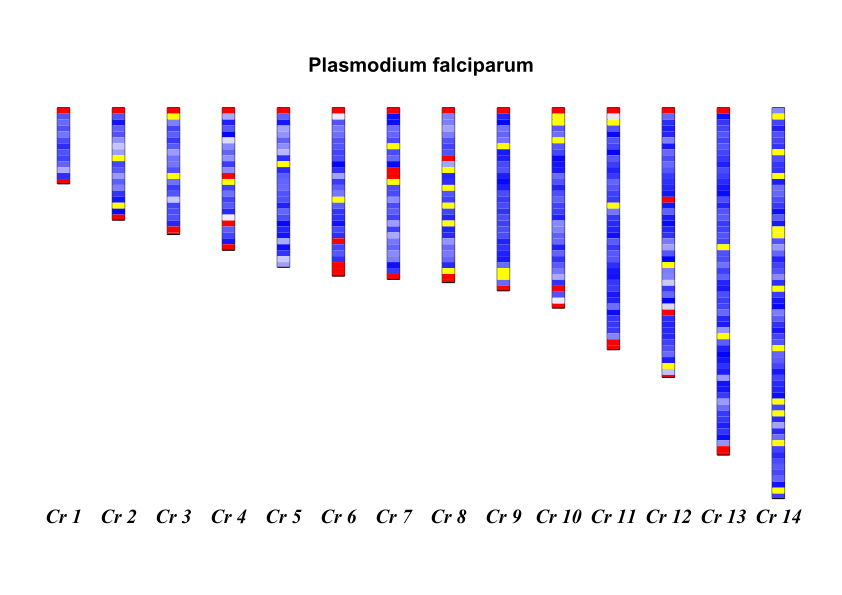

In [5]:
chroms = list(chrom_sizes.keys())
chroms.sort()

biggest_chrom = max(chrom_sizes.values())

my_genome = BasicChromosome.Organism(output_format="png")

my_genome.page_size = (29.7*cm, 21*cm) # check
telomere_length = 10

bottom_GC = 17.5
top_GC = 22.0
for chrom in chroms:
    chrom_size = chrom_sizes[chrom]
    chrom_representation = BasicChromosome.Chromosome('Cr %d' % chrom)
    chrom_representation.scale_num = biggest_chrom

    tel = BasicChromosome.TelomereSegment()
    tel.scale = telomere_length
    chrom_representation.add(tel)

    num_blocks = len(chrom_GC[chrom])
    for block, gc in enumerate(chrom_GC[chrom]):
        my_GC = chrom_GC[chrom][block]
        body = BasicChromosome.ChromosomeSegment()
        if my_GC > top_GC:
            body.fill_color = colors.Color(1, 0, 0)
        elif my_GC < bottom_GC:
            body.fill_color = colors.Color(1, 1, 0)
        else:
            my_color = (my_GC - bottom_GC) / (top_GC - bottom_GC)
            body.fill_color = colors.Color(my_color, my_color, 1)
        if block < num_blocks - 1:
            body.scale = block_size
        else:
            body.scale = chrom_size % block_size
        chrom_representation.add(body)

    tel = BasicChromosome.TelomereSegment(inverted=True)
    tel.scale = telomere_length
    chrom_representation.add(tel)

    my_genome.add(chrom_representation)

my_genome.draw("falciparum.png", "Plasmodium falciparum")
Image("falciparum.png")